# Potato Nematode Predictor
This work contains the public sector consultancy work on a potato nematode predictor carried out by Aarhus University.

Start by configuring the notebook:

In [278]:
import wget
import geopandas
import os
import rasterio
import sys
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path
from zipfile import ZipFile
from tqdm.autonotebook import tqdm

from utils import RasterstatsMultiProc

# Automatically prints execution time for the individual cells
%load_ext autotime

# Automatically reloads functions defined in external files
%load_ext autoreload
%autoreload 2

# The path to the project (so absoute file paths can be used throughout the notebook)
PROJ_PATH = Path.cwd().parent

# Define which field polygons should be used for analysis (2017 to 2019 seem to follow the same metadata format)
FIELD_POLYGONS = ['FieldPolygons2017', 'FieldPolygons2018', 'FieldPolygons2019']

# Define global flags
MULTI_PROC_ZONAL_STATS = False
ALL_TOUCHED = False

The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
time: 24.5 ms


---
Download the field polygons from The Danish Agricultural Agency:

In [2]:
# Downloaded files will go into the 'data/external' folder
dest_folder = PROJ_PATH / 'data' / 'external'
if not dest_folder.exists():
    os.makedirs(dest_folder)
    
# Define the download links for the field polygons for the individual years
file_url_mapping = {
    'FieldPolygons2016.zip': 'https://kortdata.fvm.dk/download/DownloadStream?id=3037da0f2744a85adc8b08ca5c31c3cb',
    'FieldPolygons2017.zip': 'https://kortdata.fvm.dk/download/DownloadStream?id=d0c8946763e465bf9f6160a6bc40531f',
    'FieldPolygons2018.zip': 'https://kortdata.fvm.dk/download/DownloadStream?id=cfb1b47130b7276f8515fbaae60bde2a',
    'FieldPolygons2019.zip': 'https://kortdata.fvm.dk/download/DownloadStream?id=3d19613ac986ed05a7c301319738e332'
}

# Download the zipfiles
for filename, url in file_url_mapping.items():
    dest_path = PROJ_PATH / 'data' / 'external' / filename
    if not dest_path.exists():
        wget.download(url, str(dest_path))
        print("File has been downloaded: " + filename)
    else:
        print("File already exists: " + str(PROJ_PATH / 'data' / 'external' / filename))

File already exists: /home/jovyan/work/data/external/FieldPolygons2016.zip
File already exists: /home/jovyan/work/data/external/FieldPolygons2017.zip
File already exists: /home/jovyan/work/data/external/FieldPolygons2018.zip
File already exists: /home/jovyan/work/data/external/FieldPolygons2019.zip
time: 23.3 ms


---
Then extract the zipfiles:

In [3]:
# The extracted zipfiles will go into the 'data/raw' folder
for zipfile in (PROJ_PATH / 'data' / 'external').glob('**/*.zip'):
    dest_folder = PROJ_PATH / 'data' / 'raw' / zipfile.stem   
    if not dest_folder.exists():
        with ZipFile(str(zipfile), 'r') as zipObj:
            zipObj.extractall(str(dest_folder))
        print("Zipfile has been extracted: " + str(zipfile))
    else:
        print("Zipfile has already been extracted: " + str(zipfile))

Zipfile has already been extracted: /home/jovyan/work/data/external/FieldPolygons2019.zip
Zipfile has already been extracted: /home/jovyan/work/data/external/FieldPolygons2016.zip
Zipfile has already been extracted: /home/jovyan/work/data/external/FieldPolygons2017.zip
Zipfile has already been extracted: /home/jovyan/work/data/external/FieldPolygons2018.zip
time: 25.9 ms


---
Now load the shapefiles into geopandas dataframes:

In [192]:
def load_shp(shp_name):
    # Load shapefile into dataframe and remove NaN rows
    shp_file_path = list((PROJ_PATH / 'data' / 'raw' / shp_name).glob('**/*.shp'))[0]
    df = geopandas.read_file(str(shp_file_path))
    df = df.dropna()
    
    # Change all column names to be lower-case to make the naming consistent across years (https://stackoverflow.com/a/36362607/12045808)
    df.columns = map(str.lower, df.columns)
    
    return df

# Load the dataframes into a dict, with each year as a key
df_all = {}
for df_name in FIELD_POLYGONS:
    df = load_shp(df_name)
    df_all[df_name] = df

time: 1min 29s


---
Find the potato fields and count the number of unique sorts:

In [211]:
def extract_potato_fields(df):
    # Create a new dataframe with all the different types of potatoes
    df = df[df['afgroede'].str.contains("kartof", case=False)]  

    # Find the different potato types, count the number of fields for each type, and calculate total area for each type
    for potato_type in sorted(df['afgroede'].unique()):
        num_fields = df[df['afgroede'] == potato_type].shape[0]
        sum_area = df[df['afgroede'] == potato_type]['imk_areal'].sum()
        print("There are " + str(num_fields) + " fields (total area = " + str(int(sum_area)) + " ha) of type: " + potato_type)
        
    return df 

# Extract the potato fields and load them into a new dict with each year as a key
df_potato = {}
for df_name, df in df_all.items():
    print("### Analyzing " + df_name + " ###")
    df_potato[df_name] = extract_potato_fields(df)
    print("")

### Analyzing FieldPolygons2017 ###
There are 618 fields (total area = 4773 ha) of type: Kartofler, andre
There are 88 fields (total area = 586 ha) of type: Kartofler, lægge- (certificerede)
There are 1089 fields (total area = 6626 ha) of type: Kartofler, lægge- (egen opformering)
There are 2597 fields (total area = 9223 ha) of type: Kartofler, spise-
There are 3885 fields (total area = 28040 ha) of type: Kartofler, stivelses-

### Analyzing FieldPolygons2018 ###
There are 497 fields (total area = 3693 ha) of type: Kartofler, andre
There are 317 fields (total area = 2988 ha) of type: Kartofler, lægge- (certificerede)
There are 704 fields (total area = 3700 ha) of type: Kartofler, lægge- (egen opformering)
There are 2137 fields (total area = 7805 ha) of type: Kartofler, spise-
There are 3484 fields (total area = 26235 ha) of type: Kartofler, stivelses-

### Analyzing FieldPolygons2019 ###
There are 588 fields (total area = 4877 ha) of type: Kartofler, andre
There are 465 fields (total a

---
Calculate zonal statistics for the the potato fields for the different radar data measurements:

In [212]:
tif = list((PROJ_PATH / 'data' / 'raw' / 'Sentinel-1').glob('*.tif'))[0]
with rasterio.open(tif) as src:
    tif_crs = src.crs
    print("Projection used is: " + str(tif_crs))

for df_name, df in df_potato.items():
    # Set the CRS in the geodataframe to be wkt format (otherwise you won't be able to save as a shapefile)
    df_potato[df_name] = df_potato[df_name].to_crs({'init': tif_crs})

Projection used is: EPSG:4326


/opt/conda/lib/python3.7/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))
/opt/conda/lib/python3.7/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))
/opt/conda/lib/python3.7/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


time: 2.55 s


In [ ]:
tifs = sorted((PROJ_PATH / 'data' / 'raw' / 'Sentinel-1').glob('*.tif'))
df_potato_stats = df_potato.copy()

for df_name, df in df_potato.items(): # Loop over all field polygon years
    pkl_name = df_name + '_stats' 
    pkl_path = (PROJ_PATH / 'data' / 'processed' / pkl_name).with_suffix('.pkl')
    if pkl_path.exists():
        print("Zonal statistics have already been calculated for: " + df_name)
    else:
        print("Calculating zonal statistics for: " + df_name)
        #df = df.head(20)  # For debugging to (ie. only process 20 fields)
        for tif in tqdm(tifs):  # Loop over all Sentinel-1 images
            for band in range(1, 4):  # Loop over all three bands (indexed 1 to 3)
                rasterstatsmulti = RasterstatsMultiProc(df=df, tif=tif, all_touched=ALL_TOUCHED)

                if MULTI_PROC_ZONAL_STATS:
                    results_df = rasterstatsmulti.calc_zonal_stats_multiproc()     
                else:
                    results_df = rasterstatsmulti.calc_zonal_stats(band=band, prog_bar=False) 

                del rasterstatsmulti

                stats_cols = {
                    'min': tif.stem + '_B' + str(band) + '_min',
                    'max': tif.stem + '_B' + str(band) + '_max',
                    'mean': tif.stem + '_B' + str(band) + '_mean',
                    'std': tif.stem + '_B' + str(band) + '_std',
                    'median': tif.stem + '_B' + str(band) + '_median',
                }

                results_df = results_df.rename(columns=stats_cols)

                # Note: The * operator iterates through the list (https://stackoverflow.com/a/56736691/12045808)
                df_potato_stats[df_name] = df_potato_stats[df_name].merge(results_df[['id', *stats_cols.values()]], left_on='id', right_on='id')

        if not shp_path.parent.exists():
            os.makedirs(shp_path.parent)

        # Set the CRS in the geodataframe to be wkt format (otherwise you won't be able to save as a shapefile)
        #df_potato_stats[df_name].crs = df_potato_stats[df_name].crs['init'].to_wkt()
        #df_potato_stats[df_name] = df_potato_stats[df_name].dropna()
        df_potato_stats[df_name].to_pickle(pkl_path) 

Calculating zonal statistics for: FieldPolygons2017


In [289]:
df_potato_stats['FieldPolygons2017'].head(5)

,id,imk_areal,journalnr,cvr,marknr,afgroede,afgkode,gbanmeldt,gb,geometry,...,S1B_20190820_017665_DSC_139_RGB_B2_min,S1B_20190820_017665_DSC_139_RGB_B2_max,S1B_20190820_017665_DSC_139_RGB_B2_mean,S1B_20190820_017665_DSC_139_RGB_B2_std,S1B_20190820_017665_DSC_139_RGB_B2_median,S1B_20190820_017665_DSC_139_RGB_B3_min,S1B_20190820_017665_DSC_139_RGB_B3_max,S1B_20190820_017665_DSC_139_RGB_B3_mean,S1B_20190820_017665_DSC_139_RGB_B3_std,S1B_20190820_017665_DSC_139_RGB_B3_median
0,54925491,4.70,17-0018336,34104514,3-0,"Kartofler, lægge- (egen opformering)",150.0,4.0,1.0,"POLYGON ((8.91862 56.39855, 8.91887 56.39893, ...",...,-16.0,-4.0,-8.378092,1.873387,-8.0,-2.0,17.0,7.702002,2.881975,7.0
1,54925473,4.13,17-0018336,34104514,8-0,"Kartofler, lægge- (egen opformering)",150.0,4.0,1.0,"POLYGON ((8.92149 56.39784, 8.92193 56.39857, ...",...,-16.0,-3.0,-8.705645,2.040759,-8.0,-1.0,19.0,7.717742,2.796101,8.0
2,54925508,6.68,17-0018336,34104514,9-0,"Kartofler, lægge- (egen opformering)",150.0,6.0,1.0,"POLYGON ((8.92384 56.39585, 8.92361 56.39606, ...",...,-17.0,0.0,-8.451078,2.168792,-8.0,-2.0,19.0,7.655887,2.841325,8.0
3,54925519,8.44,17-0018336,34104514,40-0,"Kartofler, lægge- (egen opformering)",150.0,8.0,1.0,"POLYGON ((8.96401 56.38641, 8.96403 56.38642, ...",...,-22.0,-6.0,-12.214567,2.279493,-12.0,-3.0,17.0,4.552493,2.715127,4.0
4,54925429,5.53,17-0018336,34104514,40-1,"Kartofler, lægge- (egen opformering)",150.0,5.0,1.0,"POLYGON ((8.96176 56.38628, 8.96238 56.38631, ...",...,-18.0,-5.0,-11.521565,2.344628,-12.0,-2.0,15.0,4.897693,2.838262,5.0


time: 56.2 ms


[-21.629329403095063, -18.692307692307693, -17.88520971302428, -20.699852507374633, -19.043446244477174, -20.416789396170838, -19.836524300441827, -17.407817109144542, -16.430678466076696, -17.848640705363703, -19.79720793534166, -17.490815576781777, -17.992652461425422, -17.851742031134172, -18.263274336283185]


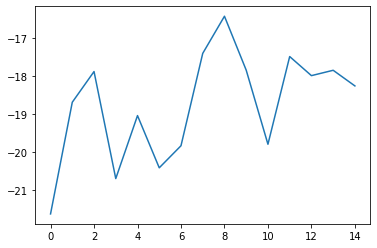

time: 174 ms


In [288]:
df_potato_stats = {}
for df_name in FIELD_POLYGONS:
    pkl_name = df_name + '_stats'
    pkl_path = (PROJ_PATH / 'data' / 'processed' / pkl_name).with_suffix('.pkl')
    df = pd.read_pickle(pkl_path)
    df_potato_stats[df_name] = df
    

x = []
for column in df_potato_stats['FieldPolygons2017']:
    if 'S1A' in column and 'B1_mean' in column:
        value = df_potato_stats['FieldPolygons2017'][column].loc[8]
        x.append(value)
    #print(df_potato_stats[column])
    
print(x)
plt.plot(x)